# Evidencia Portafolio

Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

Por: Alan Contreras Prieto - A01749667

In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
#import funcionesIA as f_IA
from funcionesIA import *
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Concatenate, Bidirectional, Attention
from tensorflow.keras.layers import Conv1D, BatchNormalization

# Introducción: 

En el sector energético moderno, la estabilidad y eficiencia de la red eléctrica dependen fundamentalmente del correcto funcionamiento de sus componentes críticos, siendo los transformadores eléctricos uno de los activos más vitales. El problema central que aborda este proyecto es la predicción de series de tiempo multivariadas para estimar el comportamiento futuro de un transformador eléctrico. Específicamente, se busca predecir la Temperatura del Aceite (OT - Oil Temperature) basándose en datos históricos de carga eléctrica y temperatura. Los transformadores generan calor durante su operación; si este calor no se disipa correctamente o excede los límites operativos, puede provocar fallos catastróficos, interrupciones del servicio y daños irreversibles al equipo.

**Relevancia**: La capacidad de predecir la temperatura del transformador con antelación tiene un impacto directo en la implementación de estrategias de mantenimiento predictivo.

* Seguridad: Previene explosiones o incendios causados por sobrecalentamiento.

* Eficiencia Económica: Reduce los costos asociados con el mantenimiento correctivo de emergencia y prolonga la vida útil de activos costosos.

* Estabilidad de la Red: Permite a los operadores gestionar mejor las cargas en horas pico, sabiendo de antemano si un transformador está en riesgo de saturación térmica.

# Datos: 


### Descripción del Dataset y fuente:

Para este proyecto se utiliza el Electricity Transformer Dataset (ETDataset), un conjunto de datos público recolectado de transformadores eléctricos reales en China.

En la carpeta data se encuentran 2 versiones de diferentes transformadores, una con registros cada 15 minutos y otra con registros cada hora.

Contenido: El dataset contiene registros históricos de dos años.

Variables: Cada registro incluye su fecha de registro y 7 variables númericas:

* date: fecha de registro

* HUFL: High Use Full Load (Carga completa de uso alto).

* HULL: High Use Less Load (Menos carga de uso alto).

* MUFL: Medium Use Full Load.

* MULL: Medium Use Less Load.

* LUFL: Low Use Full Load.

* LULL: Low Use Less Load.

* OT: Oil Temperature (Temperatura del aceite) - Variable Objetivo.

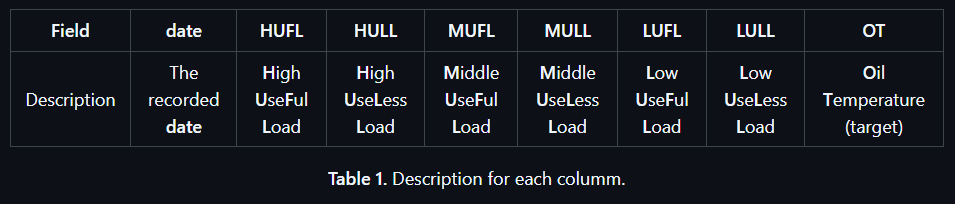

Repositorio GitHub de Zhouhaoyi - ETDataset 

Link: https://github.com/zhouhaoyi/ETDataset/

```bibtex
@inproceedings{haoyietal-informer-2021,
  author    = {Haoyi Zhou and
               Shanghang Zhang and
               Jieqi Peng and
               Shuai Zhang and
               Jianxin Li and
               Hui Xiong and
               Wancai Zhang},
  title     = {Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting},
  booktitle = {The Thirty-Fifth {AAAI} Conference on Artificial Intelligence, {AAAI} 2021, Virtual Conference},
  volume    = {35},
  number    = {12},
  pages     = {11106--11115},
  publisher = {{AAAI} Press},
  year      = {2021},
}

## Carga de datos

En el repositorio de github hay un total de 4 datasets:

Hay 2 por estación: uno con registros por hora y otro cada 15 minutos

Se usa la variable "datamin" para poder cambiar facilmente entre los dataset con el fin de usar el dataset más pequeño y adecuar la programación acorde con el fin de hacer pruebas eficientemente. 

In [168]:
datamin = False
if datamin:
    data = pd.read_csv("data/ETTm2.csv") #Version con registros cada 15 min
else:
    data = pd.read_csv("data/ETTh2.csv") #Version con registros cada hora
#
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498


## Análisis

Matriz de correlación

Información de tipos de datos y nulos

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17420 entries, 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    17420 non-null  float64
 1   HULL    17420 non-null  float64
 2   MUFL    17420 non-null  float64
 3   MULL    17420 non-null  float64
 4   LUFL    17420 non-null  float64
 5   LULL    17420 non-null  float64
 6   OT      17420 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


Estadísticas descriptivas:

In [171]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,37.193346,8.537565,43.830356,8.322694,-3.423605,-2.085969,26.609376
std,10.218855,6.020442,13.056798,4.366059,6.144403,6.012796,11.888266
min,0.000000,-18.680000,11.205000,-6.594000,-14.350000,-31.462000,-2.646500
25%,30.156000,4.523000,37.394001,5.683000,-9.254000,-2.505000,16.469500
50%,37.193001,9.131000,41.388000,9.302000,-3.774000,-1.226000,26.577000
75%,44.062000,13.152000,46.078999,11.258000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,28.736000,17.218000,2.932000,58.876999


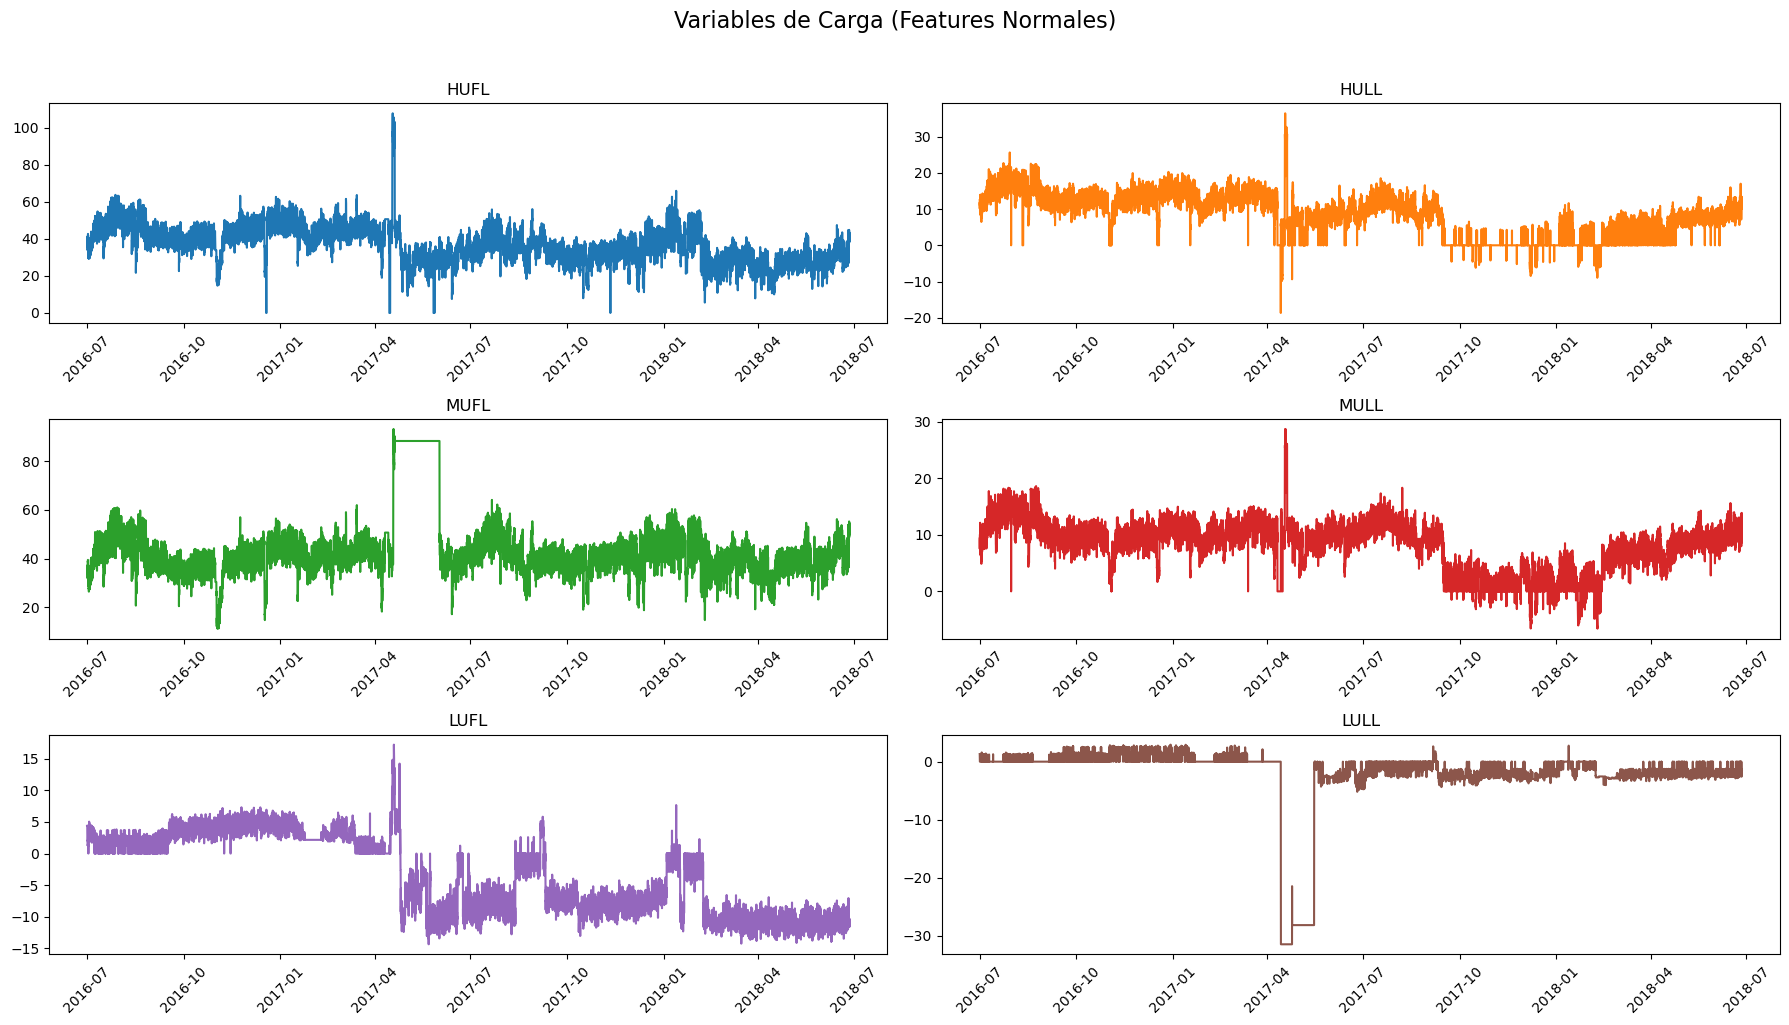

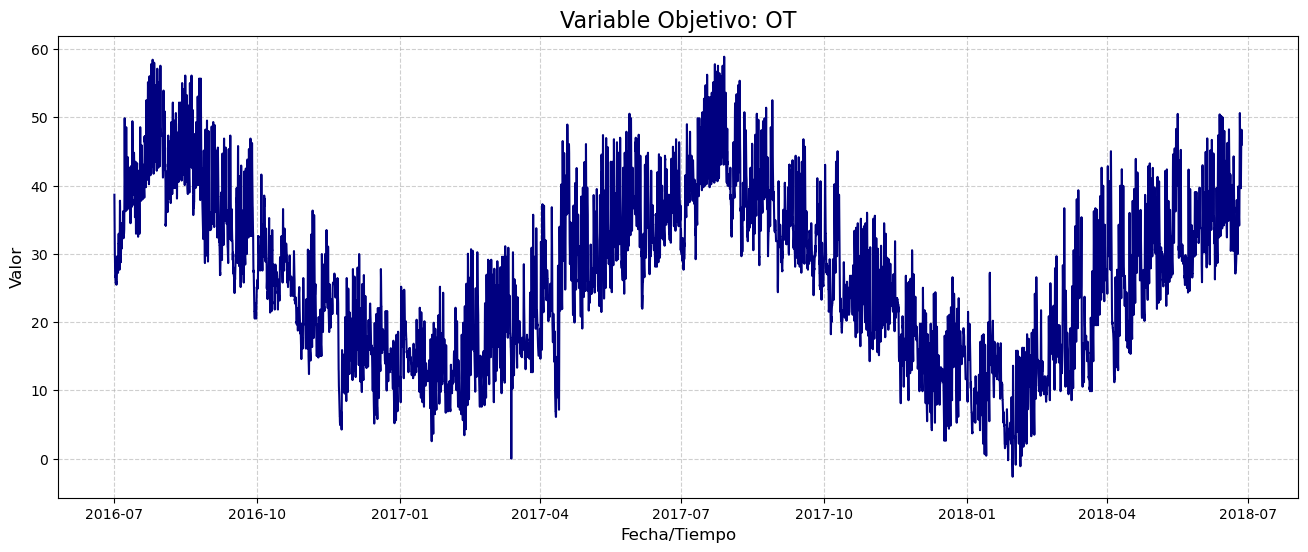

In [172]:
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
target_col   = 'OT'
plot_time_series(data, feature_cols, target_col)

## Separación en entrenamiento y prueba

In [173]:
# Agrega características de tiempo al DataFrame basado en el índice de fecha/hora.
data = add_time_features(data,datamin)

In [174]:
X = data.drop(columns=[target_col])
y = data[target_col]
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, test_size=0.25, valid_size=0.4)
X_train.shape, X_valid.shape, X_test.shape

((13065, 16), (2613, 16), (1742, 16))

## Preprocesamiento

## Escalado

In [175]:
res = scale_data(X_train, X_valid, X_test, y_train, y_valid, y_test)
X_train_s, X_valid_s, X_test_s, y_train_s, y_valid_s, y_test_s, x_scaler, y_scaler = res

## Sequencias

In [176]:
if datamin:
    SEQUENCE_LENGTH = 96 # 1 Full day = 24 hours * 4 (15 min intervals)
    #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
else:
    SEQUENCE_LENGTH = 24 # 1 Full day = 24 hours  
    #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, SEQUENCE_LENGTH)
X_valid_seq, y_valid_seq = create_sequences(X_valid_s, y_valid_s, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test_s, SEQUENCE_LENGTH)
X_train_seq.shape, y_train_seq.shape, X_valid_seq.shape, y_valid_seq.shape, X_test_seq.shape, y_test_seq.shape

N_FEATURES = X_train_seq.shape[2]  # Número total de features (cargas + temporales)

# Desarrollo del modelo: 
Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.


### Cambios en la arquitectura

La primera versión del modelo fue deliberadamente sencilla y tenía como propósito únicamente verificar el flujo de entrenamiento. Su arquitectura fue mínima:

* Una sola capa LSTM con pocas unidades

* Una capa densa final para producir la salida

* Arquitectura construida rápidamente con Sequential

Este modelo funcionó como "baseline de prueba", pero no tenía capacidad suficiente para capturar patrones temporales relevantes. La pérdida de entrenamiento disminuía ligeramente, pero el error de validación permanecía estable, indicando que el modelo no estaba aprendiendo de la secuencia.

Mejora de arquitectura

- En una iteración posterior se incorporó una capa bidireccional en la primera etapa del encoder (usando Bidirectional(LSTM(128, ...))) seguida de normalización, una segunda LSTM, un bloque de self-attention y una LSTM final para condensar la secuencia; la idea fue que la bidireccionalidad permita al modelo aprender patrones tanto hacia adelante como hacia atrás en la ventana temporal —lo cual es útil cuando la señal contiene dependencias que se benefician de contexto pasado y futuro dentro de la ventana—, mientras que LayerNormalization, kernel_regularizer y dropout controlan el mayor número de parámetros que introduce la capa bidireccional; la atención se añadió para focalizar las partes más relevantes de la secuencia y se concatena con la salida recurrente para preservar información original + ponderada, logrando así una arquitectura más expresiva que captura relaciones temporales complejas sin depender únicamente de la memoria secuencial de las LSTM.

Cambio de función de perdida:

- También se modificó la función de pérdida, pasando de MAE a Huber Loss, ya que esta última es más robusta frente a outliers y suaviza el impacto de errores muy grandes, lo cual suele beneficiar a modelos de series de tiempo con ruido o variaciones abruptas. 

- Sin embargo, el cambio no produjo mejoras significativas, por lo que se diseñó una función de pérdida personalizada enfocada en penalizar con mayor fuerza los errores cometidos en los picos o valores altos de la serie. Esta custom_loss combina un término MSE estándar con un término adicional que detecta automáticamente valores por encima de la media + desviación estándar y multiplica su error por un factor mayor, obligando al modelo a aprender mejor los comportamientos extremos que antes ignoraba. Esta modificación buscó corregir el sesgo del modelo hacia valores medios y mejorar su capacidad para seguir eventos de alta relevancia en la dinámica temporal.

Cambio de secuencias
- Se evaluó el efecto de aumentar la longitud de la secuencia por ejemplo, de 96 pasos (un día) a 672 (una semana). Esto causó un incremento drástico del tiempo por época, mayor dificultad para que la LSTM convergiera y riesgo de sobreajuste por secuencias demasiado largas. Por lo que se descartó y limitó a aumentar la secuencia a un par de días como máximo.

## Construcción del Modelo

In [177]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Concatenate, Bidirectional, Attention

def build_lstm_model(seq_len, n_feat):
    # 1. Capa de entrada
    inputs = Input(shape=(seq_len, n_feat))

    # 2. Primera LSTM (opcionalmente bidireccional)
    x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2"))(inputs)

    x = LayerNormalization()(x)

    # 3. Segunda LSTM
    x2 = LSTM(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2")(x)

    x2 = LayerNormalization()(x2)

    # 4. Bloque de Atención
    attention_output = Attention()([x2, x2])  # self-attention

    # Concateno para conservar información original + atención
    x3 = Concatenate()([x2, attention_output])

    # 5. Última LSTM para condensar la secuencia
    x4 = LSTM(32,return_sequences=False,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2")(x3)

    # 6. Dropout de regularización
    x4 = Dropout(0.2)(x4)

    # 7. Capa densa final (regresión)
    outputs = Dense(1)(x4)

    model = Model(inputs, outputs)
    return model

### Funcion de perdida

In [178]:
def custom_loss(y_true, y_pred):
    # MSE básico
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Penalización extra para valores altos (picos)
    high_value_mask = tf.cast(y_true > tf.reduce_mean(y_true) + tf.math.reduce_std(y_true), tf.float32)
    high_value_penalty = tf.reduce_mean(high_value_mask * tf.square(y_true - y_pred)) * 2.0
    
    return mse + high_value_penalty

### Construcción y compilación del modelo


In [179]:
lstm_model = build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)

optimizer = Adam(learning_rate=0.0015)

lstm_model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=["mae"]
)
lstm_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 24, 256)   │    148,480 │ input_layer_10[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 256)   │        512 │ bidirectional_9[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 24, 64)    │     82,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ lstm_28[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_9         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 24, 128)   │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ attention_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 32)        │     20,608 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ lstm_29[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         33 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 251,937 (984.13 KB)

 Trainable params: 251,937 (984.13 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [180]:
# Early Stopping para detener el entrenamiento si la pérdida de validación deja de mejorar para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida de validación
    patience=5,                # Número de épocas sin mejora antes de detener
    restore_best_weights=True   # Mantiene los mejores pesos encontrados
)

history = lstm_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=100,                 # Un número alto, ya que Early Stopping lo detendrá
    batch_size=32,
    validation_data=(X_valid_seq, y_valid_seq),
    callbacks=[early_stop] 
)

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - loss: 0.8848 - mae: 0.1141 - val_loss: 0.1158 - val_mae: 0.1091
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0582 - mae: 0.0942 - val_loss: 0.0482 - val_mae: 0.1008
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0502 - mae: 0.0984 - val_loss: 0.0388 - val_mae: 0.0982
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0248 - mae: 0.0903 - val_loss: 0.0327 - val_mae: 0.1264
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0203 - mae: 0.0881 - val_loss: 0.0351 - val_mae: 0.1034
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0185 - mae: 0.0853 - val_loss: 0.0308 - val_mae: 0.1161
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0192 - mae: 0.0865 - val_loss: 0.0250 - val_mae: 0.0944
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0177 - mae: 0.0832 - val_loss: 0.0251 - val_mae: 0.0972
Epoch 9/100
408/408 ━━━━━━━━━━━━

## Evaluación:

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.022164
Error Absoluto Medio (MAE) en Test (escalado): 0.097389
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


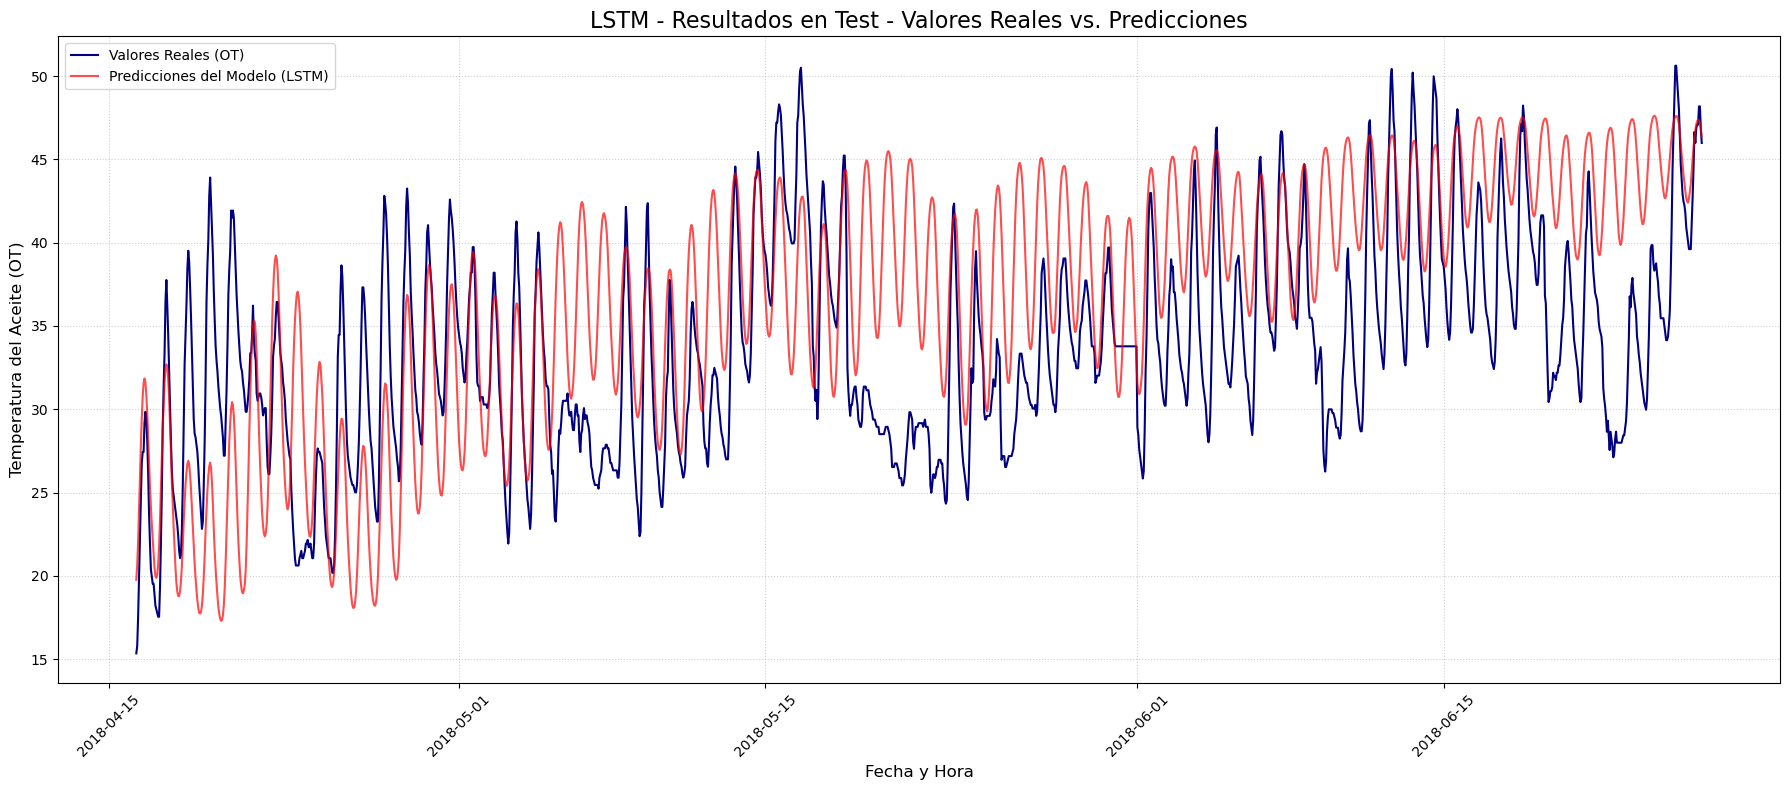

MAE en la escala Real: 5.73


In [181]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")


# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_validacion = mean_absolute_error(y_true, y_pred)
print(f"MAE en la escala Real: {mae_validacion:.2f}")

El modelo logra capturar la tendencia general de la serie, siguiendo de forma razonable el comportamiento macro del aumento y disminución de la temperatura a lo largo del tiempo. Sin embargo, se observa que es incapaz de reproducir las variaciones rápidas, fluctuaciones locales y picos característicos del proceso real. Las predicciones son demasiado suaves y muestran un patrón periódico que no coincide con la dinámica real, lo cual indica que el modelo aún no aprende adecuadamente las dependencias temporales de corto plazo ni la estructura de ruido propio del sistema.


Por lo tanto, el siguiente paso será aumentar la complejidad de la arquitectura para que el modelo sea capaz de representar patrones más finos

# Ajuste del modelo: 
Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos (al menos una iteración).

In [190]:
def new_build_lstm_model(seq_len, n_feat):
    inputs = Input(shape=(seq_len, n_feat))

    # 1. Mucho más grande
    x = Bidirectional(LSTM(
        512, return_sequences=True,
        dropout=0.0, recurrent_dropout=0.0
    ))(inputs)

    x = LayerNormalization()(x)

    # 2. Segunda LSTM más grande
    x2 = LSTM(
        256, return_sequences=True,
        dropout=0.0, recurrent_dropout=0.0
    )(x)

    x2 = LayerNormalization()(x2)

    # 3. Atención
    attention_output = Attention()([x2, x2])
    x3 = Concatenate()([x2, attention_output])

    # 4. LSTM adicional para aumentar profundidad
    x4 = LSTM(
        128, return_sequences=True,
        dropout=0.0, recurrent_dropout=0.0
    )(x3)

    x4 = LayerNormalization()(x4)

    # 5. Última LSTM (compactadora)
    x5 = LSTM(
        64, return_sequences=False,
        dropout=0.0, recurrent_dropout=0.0
    )(x4)

    # 6. SIN dropout para facilitar overfitting

    outputs = Dense(1)(x5)

    model = Model(inputs, outputs)
    return model


In [191]:
lstm_model = new_build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)

optimizer = Adam(learning_rate=0.0015)

lstm_model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=["mae"]
)
lstm_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 24, 1024)  │  2,166,784 │ input_layer_12[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 1024)  │      2,048 │ bidirectional_11… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 24, 256)   │  1,311,744 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 256)   │        512 │ lstm_35[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_11        │ (None, 24, 256)   │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 24, 512)   │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ attention_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 24, 128)   │    328,192 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ lstm_36[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         65 │ lstm_37[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,859,009 (14.72 MB)

 Trainable params: 3,859,009 (14.72 MB)

 Non-trainable params: 0 (0.00 B)

In [192]:
# Early Stopping para detener el entrenamiento si la pérdida de validación deja de mejorar para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida de validación
    patience=5,                # Número de épocas sin mejora antes de detener
    restore_best_weights=True   # Mantiene los mejores pesos encontrados
)

history = lstm_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=100,                 # Un número alto, ya que Early Stopping lo detendrá
    batch_size=32,
    validation_data=(X_valid_seq, y_valid_seq),
    callbacks=[early_stop] 
)

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 84s 189ms/step - loss: 0.0362 - mae: 0.1077 - val_loss: 0.0188 - val_mae: 0.0949
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - loss: 0.0085 - mae: 0.0639 - val_loss: 0.0211 - val_mae: 0.1013
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 86s 211ms/step - loss: 0.0071 - mae: 0.0591 - val_loss: 0.0167 - val_mae: 0.0857
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 95s 232ms/step - loss: 0.0060 - mae: 0.0538 - val_loss: 0.0179 - val_mae: 0.0849
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 142s 231ms/step - loss: 0.0055 - mae: 0.0511 - val_loss: 0.0241 - val_mae: 0.0975
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 94s 231ms/step - loss: 0.0045 - mae: 0.0464 - val_loss: 0.0241 - val_mae: 0.0999
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 95s 233ms/step - loss: 0.0040 - mae: 0.0431 - val_loss: 0.0204 - val_mae: 0.0904
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 94s 231ms/step - loss: 0.0034 - mae: 0.0396 - val_loss: 0.0190 - val_mae: 0.0890


# Resultados: 
Evaluación de modelo final con datos de prueba.


In [193]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.011943
Error Absoluto Medio (MAE) en Test (escalado): 0.070369


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


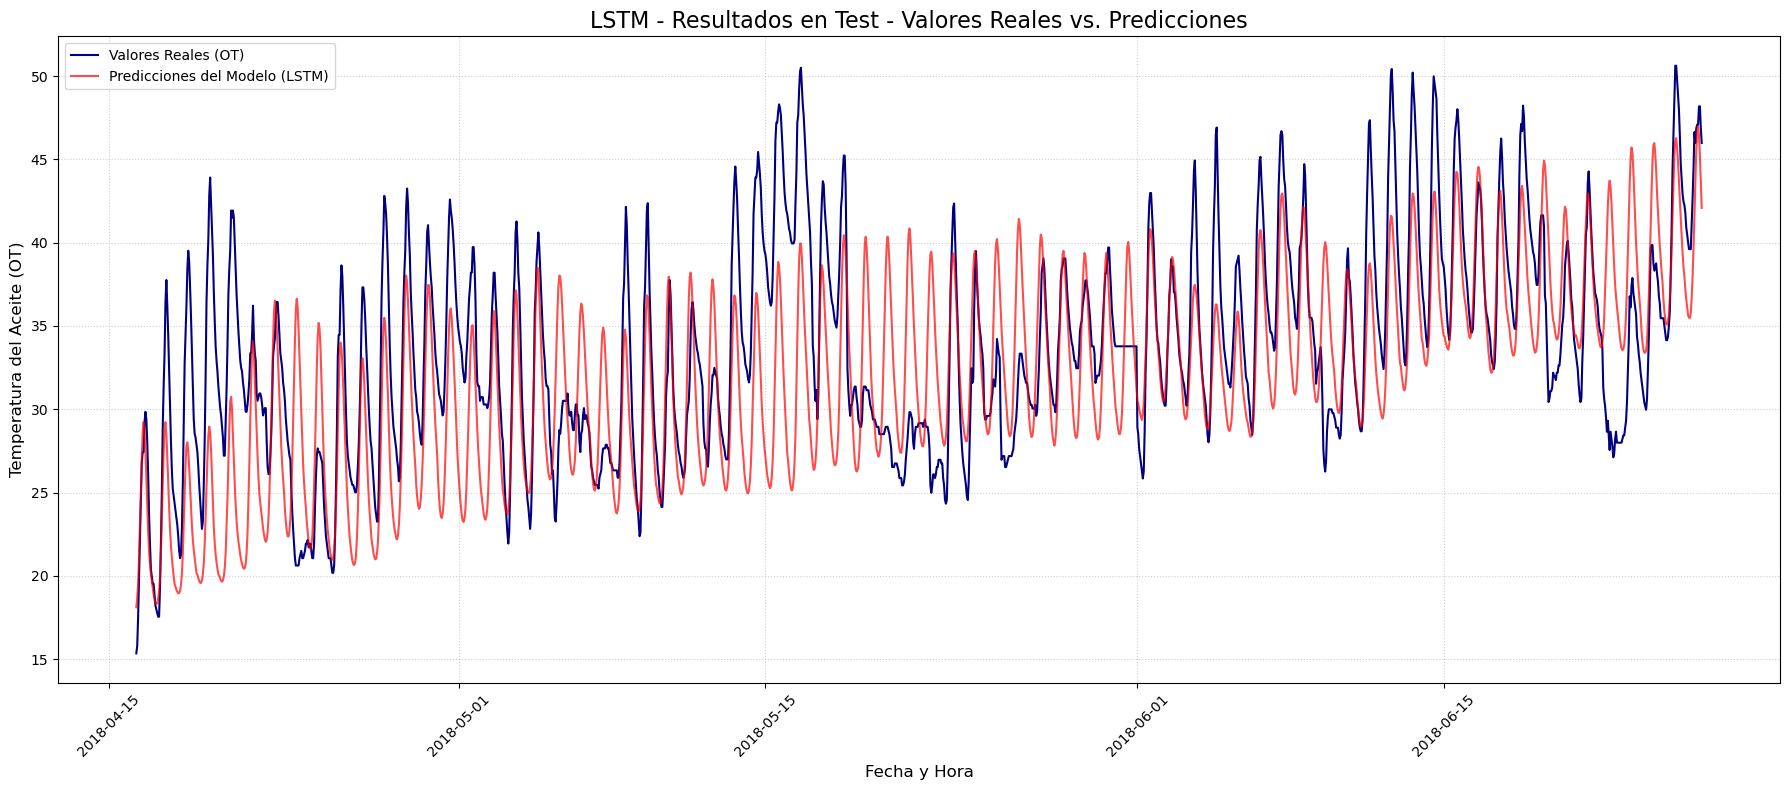

MAE validación en la escala Real: 5.73
MAE FINAL en la escala Real: 4.14


In [194]:
# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_real = mean_absolute_error(y_true, y_pred)
print(f"MAE validación en la escala Real: {mae_validacion:.2f}")
print(f"MAE FINAL en la escala Real: {mae_real:.2f}")

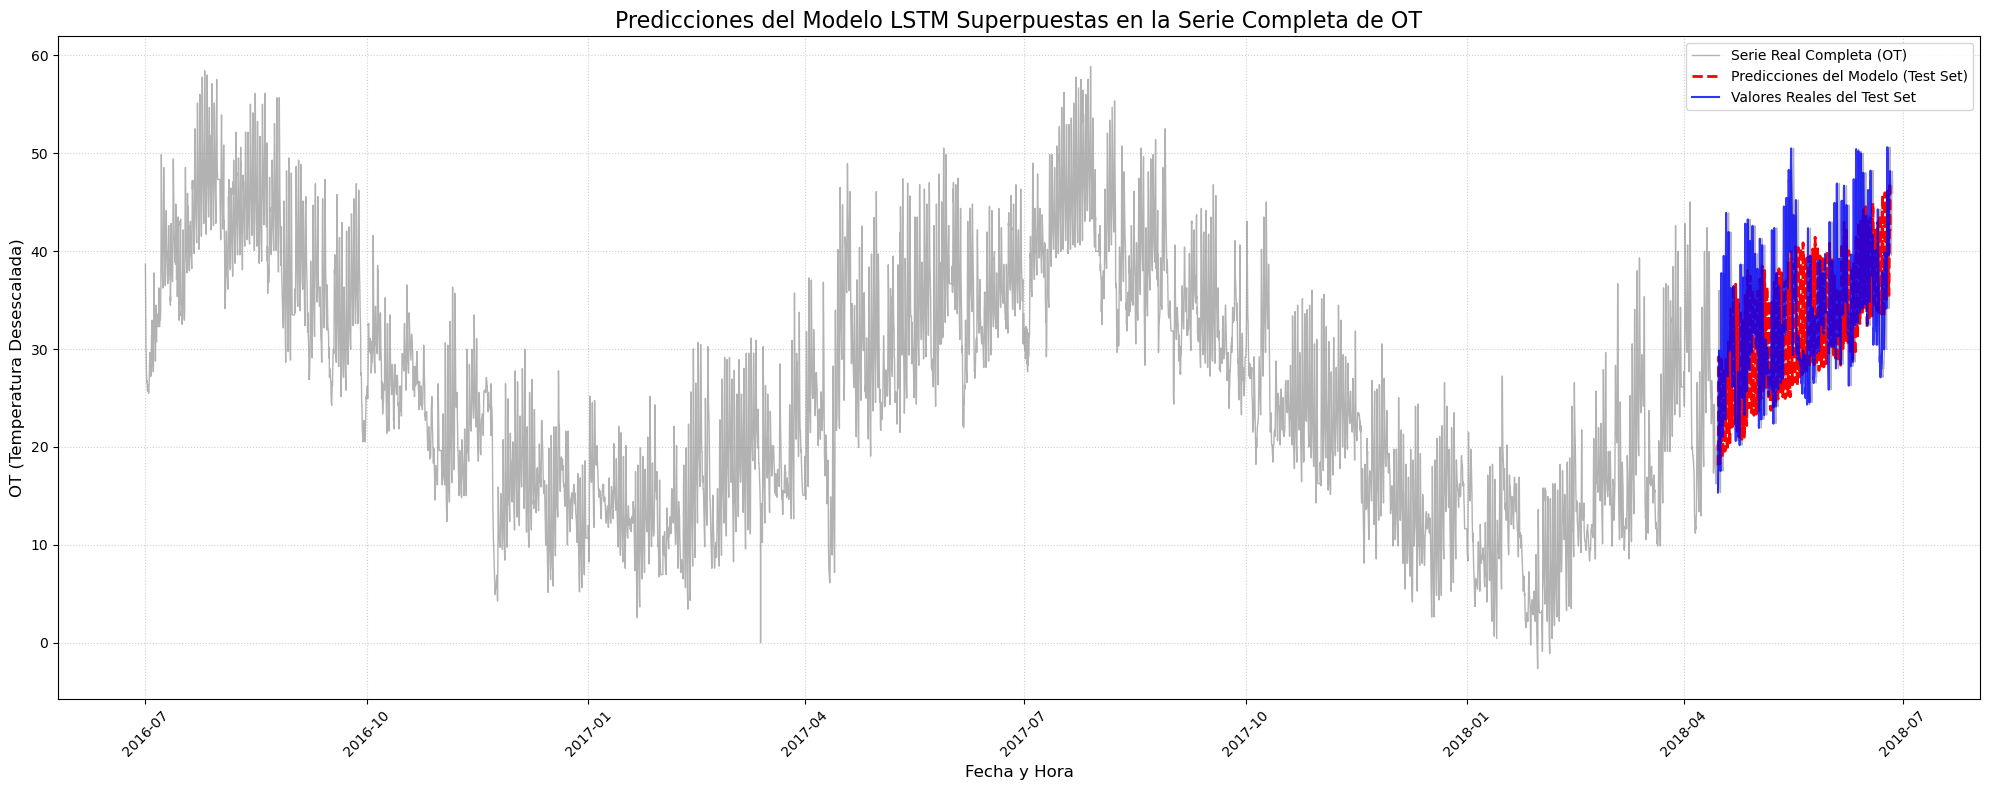

In [195]:
plot_full_series_predictions(data, target_col, y_true, y_pred, len(X_train_seq)+len(X_valid_seq), 2 *SEQUENCE_LENGTH)

# Conclusiones: 
Análisis de los resultados obtenidos, identificación de posibles áreas de mejora.

Las predicciones muestran que el modelo es capaz de representar correctamente la tendencia global de la temperatura del aceite a lo largo del tiempo. En los gráficos se observa cómo las curvas generadas por el LSTM siguen de manera coherente los movimientos lentos y el comportamiento estacional de la serie, incluso manteniendo patrones consistentes en diferentes rangos temporales. Esto indica que la red logró aprender la estructura de largo plazo y la dinámica suave del sistema, lo cual constituye un avance respecto a las versiones previas del modelo simple.

A pesar del aumento en la complejidad de la arquitectura, el modelo continúa teniendo problemas para reproducir los cambios abruptos presentes en los valores reales. Las oscilaciones de alta frecuencia y los picos característicos de la serie siguen siendo suavizados por la red. En las comparaciones visuales entre valores reales y predichos se aprecia que el modelo responde con curvas onduladas y regulares, lo que sugiere que, incluso con mayor capacidad, la red no logró representar correctamente la variabilidad de corto plazo. Esto implica que la arquitectura actual no es suficiente para modelar los componentes más inestables o ruidosos de la señal.

El comportamiento repetitivo y excesivamente regular de las predicciones indica que el modelo tiene un sesgo inductivo fuerte hacia patrones limpios y periódicos. Cuando la red no logra modelar la complejidad real de la serie, tiende a colapsar hacia formas onduladas que se repiten, ya que estas representaciones minimizan el error sin necesidad de capturar detalles más ruidosos o irregulares. Esto explica por qué incluso la penalización en los picos dentro de la función de pérdida no generó cambios significativos: el modelo prefiere soluciones estables y predecibles antes que aproximar fluctuaciones impredecibles. Este comportamiento revela que la arquitectura actual no está siendo suficiente para representar la complejidad real de los datos.

La comparación entre las predicciones y los valores reales en el conjunto de prueba muestra una discrepancia clara en términos de variabilidad: mientras que los datos verdaderos presentan un comportamiento notablemente más ruidoso, las predicciones permanecen suaves y limpias. Esto sugiere que la ventana temporal utilizada actualmente no contiene suficiente información para que el modelo pueda inferir los movimientos bruscos. Es posible que la dinámica de corto plazo dependa de patrones más largos que no están siendo capturados, o incluso de variables exógenas que no están incluidas en las características de entrada. En este caso, la limitación no es solo de arquitectura, sino también de información disponible para el modelo.

## Áreas de mejora

Probar arquitecturas especializadas en capturar alta frecuencia

Por ejemplo:

* TCN (Temporal Convolutional Network): Muy buena para variaciones abruptas.
Muchas veces supera a LSTM en señales ruidosas.

* LSTM + CNN híbrido: CNN captura ruido de corto plazo; LSTM tendencia larga.

* Transformers (encoder-only): Mucho más eficientes que LSTM + atención de Keras.

### Transfer Learning 

Se consideró una idea:
Entrenar primero con datos cada hora

Hacer fine-tuning con datos cada 15 minutos

Conclusión: Es posible, pero requiere escalar ambos datasets de la misma forma y adaptar ventanas. Se dejó como posible área para mejorar resultados.

# Aplicación: 
Función para probar modelo con datos nuevos (por ejemplo, argumento=ruta a imagen, salida=resultado de clasificación).


In [196]:
def app(data,datamin,scaladorx,scaladory,timeseriesmodel):
    # index de fecha/hora
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    # Time features
    data = add_time_features(data,datamin)
    
    # Escalado de datos
    target_col   = 'OT'
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    X_scaled = scaladorx.transform(X)
    y_scaled = scaladory.transform(y.values.reshape(-1,1)).flatten()

    # Secuencias
    if datamin:
        SEQUENCE_LENGTH = 96 # 1 Full day = 24 hours * 4 (15 min intervals)
        #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
    else:
        SEQUENCE_LENGTH = 24 # 1 Full day = 24 hours  
        #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

    print("Evaluando el modelo en el conjunto de prueba...")
    loss, mae = timeseriesmodel.evaluate(X_seq, y_seq, verbose=0)

    print(f"\n--- Resultados de la Prueba ---")
    # El error está en la escala escalada (0 a 1)
    print(f"Pérdida (MSE) en Test (escalado): {loss:.6f}")
    print(f"Error Absoluto Medio (MAE) en Test (escalado): {mae:.6f}")


    # 1. Generar Predicciones (Aún en la escala de 0 a 1)
    y_pred_scaled = timeseriesmodel.predict(X_seq).flatten()

    # 2. Desescalar 
    y_pred = scaladory.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaladory.inverse_transform(y_seq.reshape(-1, 1)).flatten()
    plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en con datos nuevos")
    mae_validacion = mean_absolute_error(y_true, y_pred)
    print(f"MAE en la escala Real: {mae_validacion:.2f}")


## Prueba con un conjunto de datos alternativos de otra estación.

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.051591
Error Absoluto Medio (MAE) en Test (escalado): 0.173816
544/544 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step


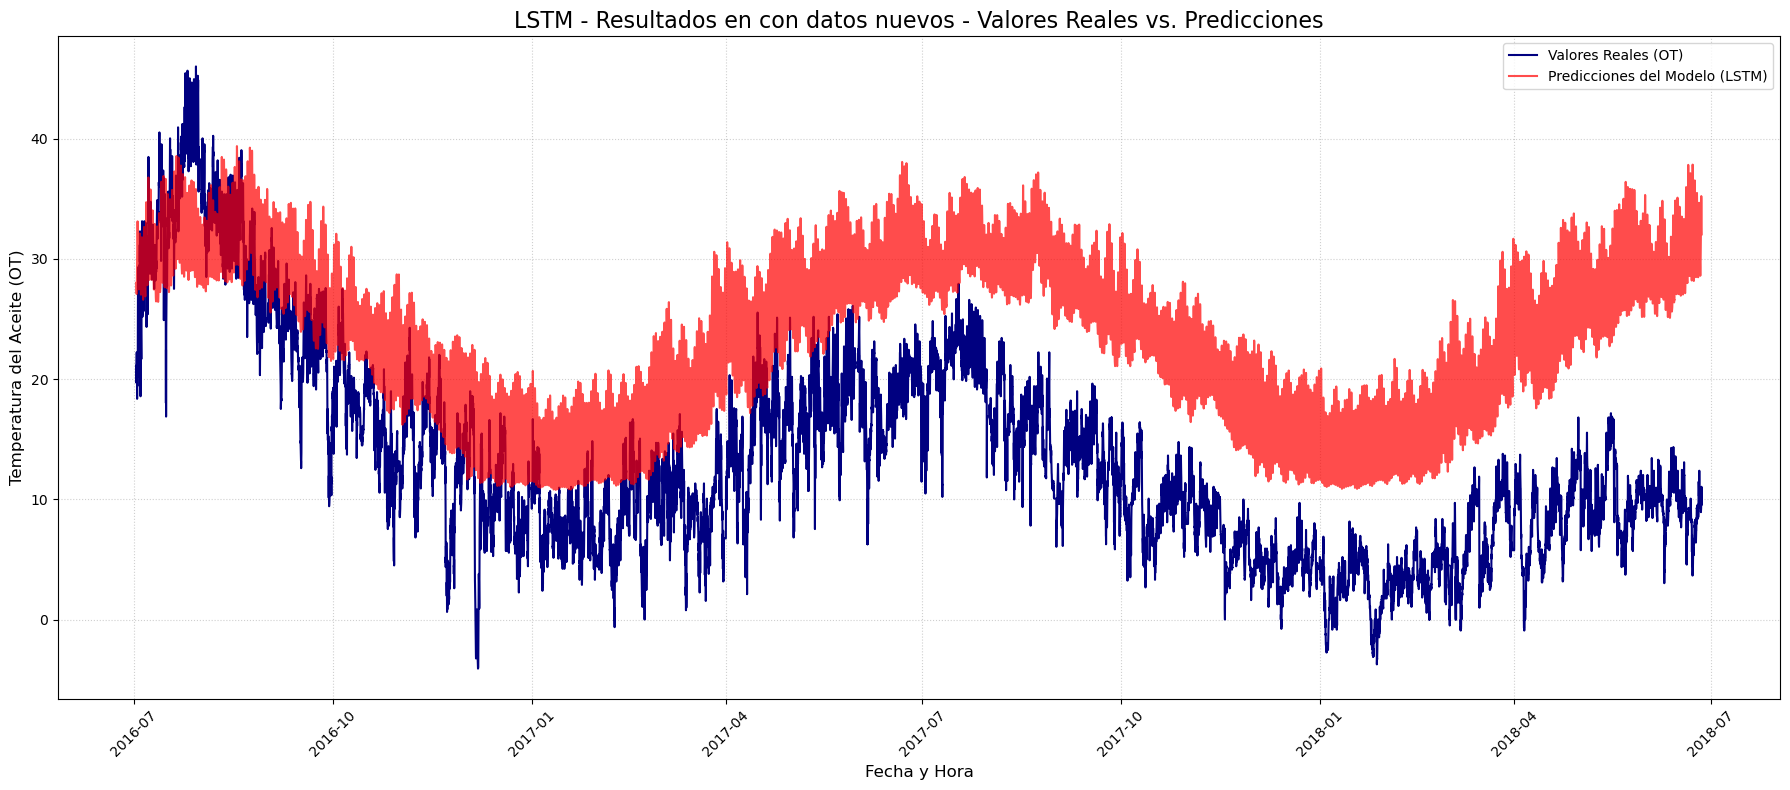

MAE en la escala Real: 10.23


In [197]:
if datamin:
    dataprueba = pd.read_csv("data/ETTm1.csv") #Version con registros cada 15 min
else:
    dataprueba = pd.read_csv("data/ETTh1.csv") #Version con registros cada hora

app(dataprueba,datamin,x_scaler,y_scaler,lstm_model)

Cuando el modelo LSTM se aplica sobre datos provenientes de una estación distinta a aquella utilizada durante el entrenamiento, es normal observar una discrepancia considerable en los valores exactos de las predicciones. Esto ocurre porque cada estación tiene condiciones térmicas particulares: microclimas distintos, variaciones de exposición solar, diferencias en el hardware de medición o incluso dinámicas propias del sitio. El modelo, al no haber visto estos valores específicos durante el entrenamiento, tiende a mantener el rango, el nivel y la estructura de las temperaturas aprendidas en la estación original, lo que explica el desplazamiento vertical claro entre los valores reales y las predicciones.

A pesar de ese error evidente en la magnitud absoluta, el gráfico muestra que el modelo sí es capaz de capturar el patrón temporal subyacente. Las predicciones reproducen casi con exactitud la forma general del comportamiento anual: los picos, los valles, la estacionalidad y las variaciones lentas a lo largo del tiempo. Esto indica que el modelo internalizó correctamente las relaciones dinámicas entre las variables que determinan la temperatura del aceite, pero también que esas relaciones son similares entre estaciones, aun cuando sus rangos numéricos no coinciden.


Este resultado demuestra un punto importante: el modelo tiene una generalización parcial. No es capaz de trasladar perfectamente los niveles absolutos de temperatura a una nueva estación, pero sí aprende el ritmo o la estructura temporal del fenómeno físico. En muchos problemas reales este tipo de generalización es valiosa: aunque los valores exactos sean distintos, el modelo captura la tendencia, el período y la forma del cambio, lo que podría aprovecharse con técnicas adicionales como recalibración, regresión lineal post-procesamiento o transfer learning.

Finalmente, la diferencia marcada entre predicción y realidad pone en evidencia que el modelo está mal calibrado para esta nueva estación, pero no completamente errado. Esto abre la puerta a dos caminos: o bien entrenar con datos mezclados de ambas estaciones para mejorar generalización, o bien crear un modelo por estación para lograr mejor precisión. En cualquier caso, este tipo de prueba es crucial para entender las limitaciones reales del modelo y comprobar que, aun con sus fallos, sí es capaz de aprender y reproducir el patrón fundamental del sistema.